# Parsing Poison Removal Results

This notebook parses the output files from different filtering methods (PCA, k-means, and quantum) and extracts the number of poison samples removed in each epoch, as well as the detailed quantum filter results for each k value.

In [1]:
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# import scienceplots
import seaborn as sns
import numpy as np

# Set plot style
plt.style.use("ggplot")
# plt.style.use(['science','ieee'])
sns.set_theme(style="whitegrid")

## Read and Parse the Output Files

We'll read each epoch file and extract the poison_removed values for each filter type, as well as the detailed quantum filter results for each k value.

In [2]:
def parse_epoch_file(epoch_num):
    """Parse an epoch file and extract poison_removed values for each filter type.

    Args:
        epoch_num: The epoch number to process
    """
    filepath = f"epoch_{epoch_num}.txt"

    # Check if file exists
    if not os.path.exists(filepath):
        print(f"Error: File {filepath} not found")
        return None

    with open(filepath, "r") as f:
        content = f.read()

    # Extract poison_removed values for each filter
    pca_match = re.search(
        r"Running PCA filter\s*\(poison_removed, clean_removed\) = \(([0-9]+)", content
    )
    kmeans_match = re.search(
        r"Running kmeans filter\s*\(poison_removed, clean_removed\) = \(([0-9]+)",
        content,
    )

    # For quantum filter, we need the best result
    quantum_best_match = re.search(
        r"\(best_k, best_opnorm\) = \(([0-9]+), ([0-9.]+)\)", content
    )
    # Extract the quantum filter results, accounting for any text between
    quantum_final_match = re.search(
        r"Running quantum filter.*?\(poison_removed, clean_removed\) = \(([0-9]+)",
        content,
        re.DOTALL,
    )

    # Extract detailed quantum filter results for each k value
    quantum_pattern = r"\(k, op, poison_removed\) = \(([0-9]+), ([0-9\.]+), ([0-9]+)\)"
    quantum_details = re.findall(quantum_pattern, content)

    # Convert to appropriate data types
    quantum_details_parsed = []
    for k, op, pr in quantum_details:
        quantum_details_parsed.append(
            {
                "epoch": epoch_num,
                "k": int(k),
                "op": float(op),
                "poison_removed": int(pr),
            }
        )

    pca_poison_removed = int(pca_match.group(1)) if pca_match else None
    kmeans_poison_removed = int(kmeans_match.group(1)) if kmeans_match else None
    quantum_poison_removed = (
        int(quantum_final_match.group(1)) if quantum_final_match else None
    )
    quantum_best_k = int(quantum_best_match.group(1)) if quantum_best_match else None
    quantum_best_que = (
        float(quantum_best_match.group(2)) if quantum_best_match else None
    )

    return {
        "epoch": epoch_num,
        "pca_poison_removed": pca_poison_removed,
        "kmeans_poison_removed": kmeans_poison_removed,
        "quantum_poison_removed": quantum_poison_removed,
        "quantum_best_k": quantum_best_k,
        "quantum_best_que": quantum_best_que,
        "quantum_details": quantum_details_parsed,
    }

In [3]:
results = []
quantum_k_results = []
for epoch in range(1, 6):
    result = parse_epoch_file(epoch)
    if result:
        quantum_k_results.extend(result["quantum_details"])
        result.pop("quantum_details")
        results.append(result)

# Convert results to DataFrame for easier analysis
df = pd.DataFrame(results)
df.sort_values("epoch", inplace=True)

# Create a DataFrame for the quantum filter k-value results
quantum_df = pd.DataFrame(quantum_k_results)
quantum_df.sort_values(["epoch", "k"], inplace=True)

In [4]:
df

,epoch,pca_poison_removed,kmeans_poison_removed,quantum_poison_removed,quantum_best_k,quantum_best_que
0,1,1624,747,2378,52,1455.297003
1,2,2131,625,2380,64,4247.820667
2,3,2016,586,2380,24,6174.990587
3,4,1142,581,2366,17,3507.303067
4,5,444,483,1243,17,2038.365547


In [5]:
quantum_df

,epoch,k,op,poison_removed
0,1,1,12.944059,1624
1,1,3,63.224391,2048
2,1,7,861.022093,2367
3,1,11,1291.650970,2377
4,1,17,1378.773863,2378
5,1,24,1393.486773,2378
6,1,32,1404.217199,2378
7,1,42,1441.704913,2378
8,1,52,1455.297003,2378
9,1,64,1385.078483,2376


## Visualize Poison Removal Effectiveness

Let's create visualizations to compare the effectiveness of each filter type across epochs.

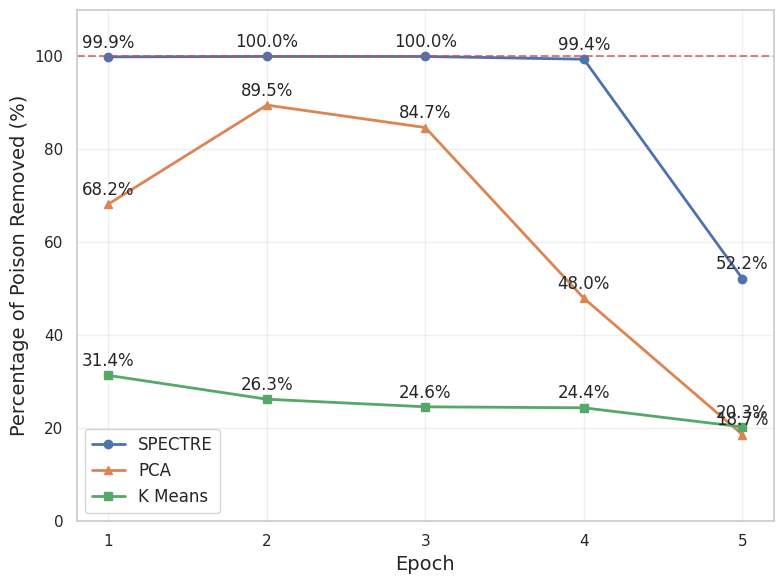

In [6]:
plt.figure(figsize=(8, 6))

# Calculate percentages for each filter
total_poison_samples = 2380
df["pca_percent"] = df["pca_poison_removed"] / total_poison_samples * 100
df["kmeans_percent"] = df["kmeans_poison_removed"] / total_poison_samples * 100
df["quantum_percent"] = df["quantum_poison_removed"] / total_poison_samples * 100

# Plot lines for each filter type using percentages
plt.plot(df["epoch"], df["quantum_percent"], "o-", label="SPECTRE", linewidth=2)
plt.plot(df["epoch"], df["pca_percent"], "^-", label="PCA", linewidth=2)
plt.plot(df["epoch"], df["kmeans_percent"], "s-", label="K Means", linewidth=2)

# Add a horizontal line at 100% (all poison samples)
plt.axhline(y=100, color="r", linestyle="--", alpha=0.7)

# Customize plot
# plt.title(
#     "Percentage of Poison Removed by SPECTRE",
#     fontsize=16,
# )
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Percentage of Poison Removed (%)", fontsize=14)
plt.xticks(df["epoch"])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Set y-axis to start from 0 and go to slightly above 100
plt.ylim(bottom=0, top=110)

# Add percentage labels above each point
for i, epoch in enumerate(df["epoch"]):
    plt.text(
        epoch,
        df["pca_percent"].iloc[i] + 2,
        f"{df['pca_percent'].iloc[i]:.1f}%",
        ha="center",
    )
    plt.text(
        epoch,
        df["kmeans_percent"].iloc[i] + 2,
        f"{df['kmeans_percent'].iloc[i]:.1f}%",
        ha="center",
    )
    plt.text(
        epoch,
        df["quantum_percent"].iloc[i] + 2,
        f"{df['quantum_percent'].iloc[i]:.1f}%",
        ha="center",
    )
plt.tight_layout()
plt.show()

## Analysis of Quantum Filter Parameters

Let's look at how the best k value for the quantum filter changes across epochs.

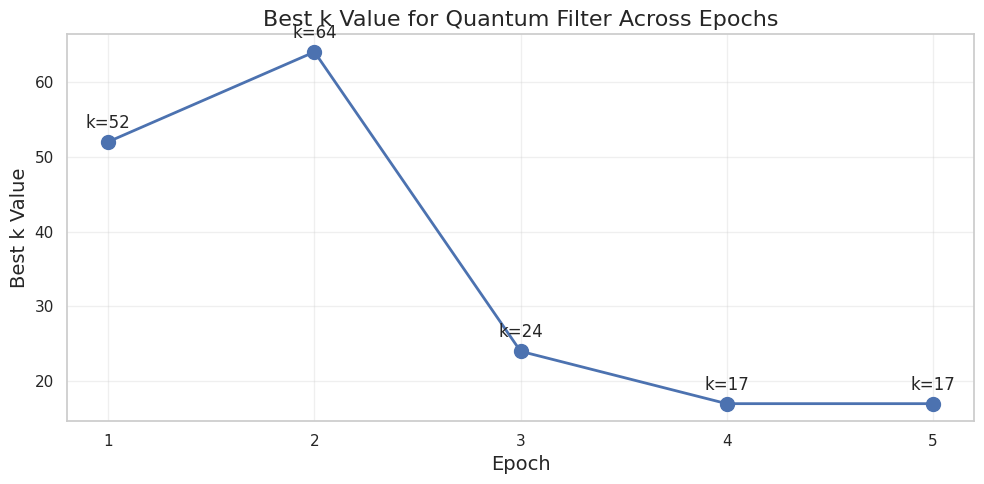

In [26]:
plt.figure(figsize=(10, 5))

plt.plot(df["epoch"], df["quantum_best_k"], "o-", markersize=10, linewidth=2)
plt.title("Best k Value for Quantum Filter Across Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Best k Value", fontsize=14)
plt.xticks(df["epoch"])
plt.grid(True, alpha=0.3)

for i, txt in enumerate(df["quantum_best_k"]):
    plt.annotate(
        f"k={txt}",
        (df["epoch"].iloc[i], df["quantum_best_k"].iloc[i]),
        xytext=(0, 10),
        textcoords="offset points",
        ha="center",
    )

plt.tight_layout()
plt.show()

## Visualization of Quantum Entropy Score vs. k Value

Let's create a visualization showing the relationship between k values and quantum entropy scores (op) for each epoch.

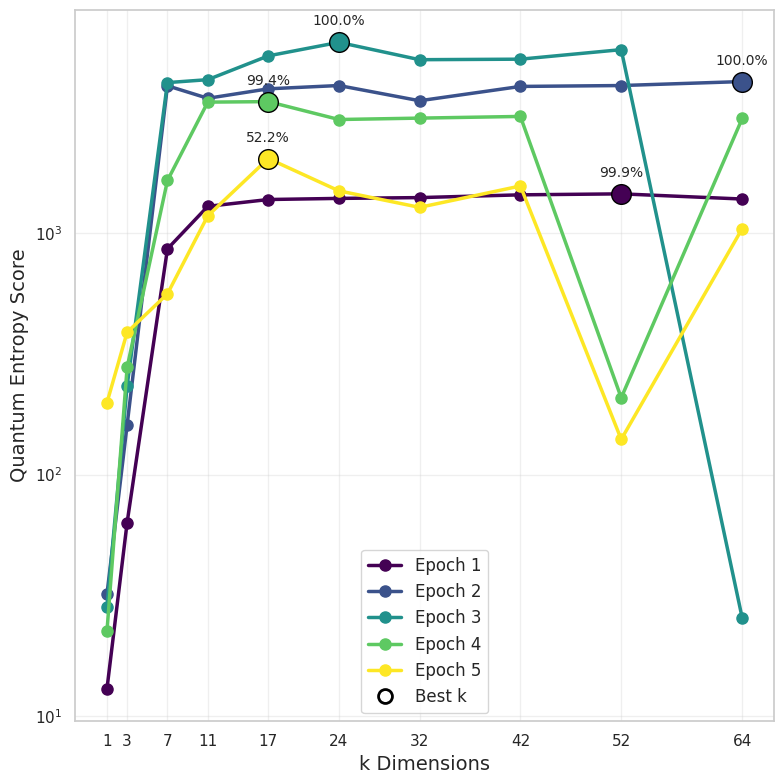

In [26]:
from matplotlib.lines import Line2D

plt.figure(figsize=(8, 8))

# Create a color map for different epochs
colors = plt.cm.viridis(np.linspace(0, 1, len(df["epoch"].unique())))

# Plot each epoch as a separate line
for i, epoch in enumerate(sorted(quantum_df["epoch"].unique())):
    epoch_data = quantum_df[quantum_df["epoch"] == epoch]

    # Plot the line
    plt.plot(
        epoch_data["k"],
        epoch_data["op"],
        "o-",
        label=f"Epoch {epoch}",
        color=colors[i],
        linewidth=2.5,
        markersize=8,
    )

    # Mark the best k value for each epoch
    best_k = df[df["epoch"] == epoch]["quantum_best_k"].values[0]
    best_op = epoch_data[epoch_data["k"] == best_k]["op"].values[0]
    plt.scatter(best_k, best_op, s=200, color=colors[i], edgecolor="black", zorder=5)

# Add chart labels and styling
# plt.title("Quantum Entropy Score by k Dimensions", fontsize=18)
plt.xlabel("k Dimensions", fontsize=14)
plt.ylabel("Quantum Entropy Score", fontsize=14)
plt.grid(True, alpha=0.3)

# Add log scale for y-axis since the op values vary greatly
plt.yscale("log")

# X-axis ticks at each k value tested
plt.xticks(sorted(quantum_df["k"].unique()))

# Annotate each best k value with its effectiveness
for i, epoch in enumerate(sorted(quantum_df["epoch"].unique())):
    epoch_data = df[df["epoch"] == epoch]
    best_k = epoch_data["quantum_best_k"].values[0]
    best_op = quantum_df[(quantum_df["epoch"] == epoch) & (quantum_df["k"] == best_k)][
        "op"
    ].values[0]
    poison_removed = epoch_data["quantum_poison_removed"].values[0]
    percent_removed = epoch_data["quantum_percent"].values[0]

    plt.annotate(
        f"{percent_removed:.1f}%",
        xy=(best_k, best_op),
        xytext=(0, 15),
        textcoords="offset points",
        # bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
        fontsize=10,
        ha="center",
        va="center",
    )

# Add a special legend element for the best k values

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="w",
        markeredgecolor="black",
        markeredgewidth=2,
        markersize=10,
        label="Best k",
    )
)

plt.legend(handles=handles, fontsize=12)
plt.tight_layout()
plt.show()

## Quantum Entropy Score vs Poison Removal Percentage

Let's examine the relationship between quantum entropy score (op) and the percentage of poison samples removed. This will help us understand if higher entropy scores generally correlate with better poison detection.

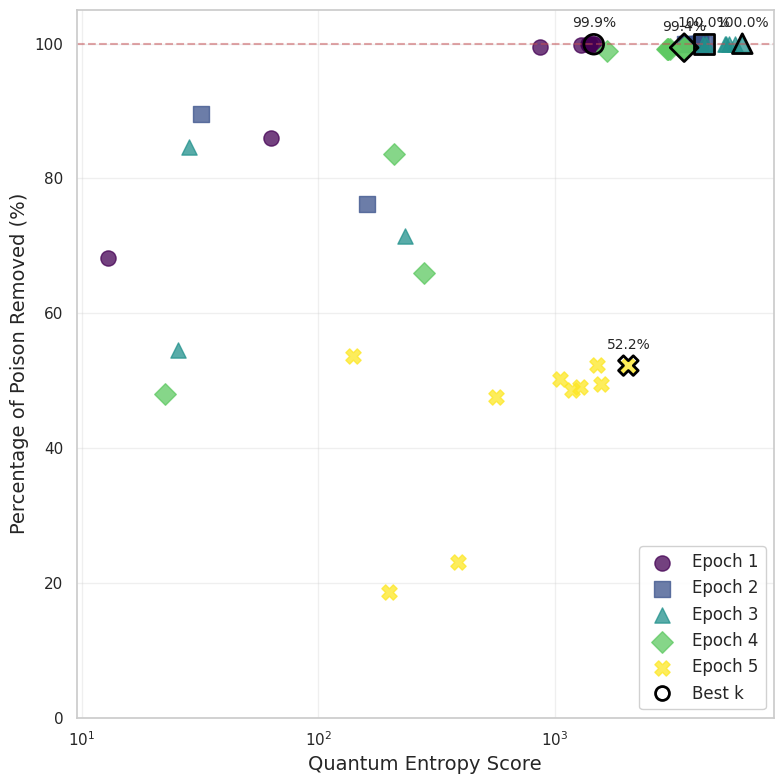

In [19]:
# Add percentage of poison removed to quantum_df (if not already added)
if "percent_removed" not in quantum_df.columns:
    quantum_df["percent_removed"] = (
        quantum_df["poison_removed"] / total_poison_samples * 100
    )

# Create a scatter plot with entropy score vs poison removal percentage
plt.figure(figsize=(8, 8))

# Define a discrete colormap for the 5 epochs
epoch_colors = plt.cm.viridis(np.linspace(0, 1, 5))
epoch_cmap = mcolors.ListedColormap(epoch_colors)

# Create a custom normalization to ensure discrete color mapping
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = mcolors.BoundaryNorm(bounds, epoch_cmap.N)

# Plot each epoch as a separate scatter plot with different markers
markers = ["o", "s", "^", "D", "X"]
for i, epoch in enumerate(sorted(quantum_df["epoch"].unique())):
    epoch_data = quantum_df[quantum_df["epoch"] == epoch]

    # Get best k info for this epoch
    best_k = df[df["epoch"] == epoch]["quantum_best_k"].values[0]
    percent_at_best_k = df[df["epoch"] == epoch]["quantum_percent"].values[0]

    # Plot with more descriptive legend labels including the best k value
    plt.scatter(
        epoch_data["op"],
        epoch_data["percent_removed"],
        c=[epoch_colors[i]],  # Use single color from colormap
        marker=markers[i],
        s=120,
        alpha=0.75,
        label=f"Epoch {epoch}",
    )

    # Mark the best k value for each epoch
    best_point = epoch_data[epoch_data["k"] == best_k]

    plt.scatter(
        best_point["op"],
        best_point["percent_removed"],
        s=200,
        facecolors="none",
        edgecolors="black",
        linewidths=2,
        marker=markers[i],
        zorder=10,
    )
    plt.annotate(
        f"{percent_at_best_k:.1f}%",
        xy=(best_point["op"].values[0], best_point["percent_removed"].values[0]),
        xytext=(0, 15),
        textcoords="offset points",
        # bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
        fontsize=10,
        ha="center",
        va="center",
    )

# Add a horizontal line at 100% (all poison samples)
plt.axhline(y=100, color="r", linestyle="--", alpha=0.5)

# Customize plot
# plt.title("Poison Removal vs Quantum Entropy Score", fontsize=16)
plt.xlabel("Quantum Entropy Score", fontsize=14)
plt.ylabel("Percentage of Poison Removed (%)", fontsize=14)
plt.xscale("log")
plt.grid(True, alpha=0.3)

# Create a combined legend
from matplotlib.lines import Line2D

# Add a legend element for the best k values
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="w",
        markeredgecolor="black",
        markeredgewidth=2,
        markersize=10,
        label="Best k",
    )
]

# Add both epoch legends and the best k value legend in a single legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend(legend_elements)
plt.legend(handles=handles, loc="lower right", fontsize=12, framealpha=0.9)

# Set y-axis to start from 0 and go to slightly above 100
plt.ylim(bottom=0, top=105)

plt.tight_layout()
plt.show()

## Summary

This notebook has:
1. Parsed raw output data containing poison_removed values
2. Extracted values for PCA, kmeans, and quantum methods
3. Extracted detailed quantum filter results for each k value tested
4. Organized the data into structured formats
5. Visualized the results
6. Saved the data in multiple formats for future use